# Bagging and Random Forest Classifier

In this notebook, we will implement **multiclass MNIST digit recognition classifier** with **decision tree** and **ensemble techniques**.

# Imports

In [1]:
# plotting utility
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# dataset loading through mnist.
from keras.datasets import mnist

# training three classifiers: decision tree, bagging and random forest.
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# model selection utilities for training and test splot and cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

# use shuffle-split cross validation for this exercise
from sklearn.model_selection import ShuffleSplit

# make use of metrics like confusion matrix and classification report to evaluate the performance on the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# the model is defined through pipeline utility
from sklearn.pipeline import Pipeline

# preprocessing for scaling the input
from sklearn.preprocessing import StandardScaler

# Loading MNIST dataset

We begin by loading MNIST dataset with `load_data` function in `mnist` class.

We obtain:
- Training feature matrix and labels
- Test feature matrix and labels

In [2]:
# Load dataset
(X_train, y_train),(X_test, y_test) = mnist.load_data()

There are $60000$ examples in training set and $10000$ examples in the test set.

Each example is a grey scale image of $28 \times 28$. There are $10$ different labels - one for each digit - $0$ to $9$.

In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Before using the dataset for training and evaluation, we need to flatten it into a vector. After flattening, we have training and test examples represented with a vector of $784$ features. Each feature records pixrl intensity in each of $28 \times 28$ pixel.

We normalize the pixel intensity by dividing it with the maximum value i.e. $255$. In that sense we have each feature value in the range of $0$ to $1$.

In [4]:
# Flatten each input image into a vector of length 784
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# Normalizing
X_train = X_train/255
X_test = X_test/255

In [5]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


We use `ShuffleSplit` cross validation with $10$ splits and $20\%$ of the data set aside for model evaluation as a test data.

In [6]:
shufflesplit_cv = ShuffleSplit(
    n_splits=10,
    test_size=0.2,
    random_state=69
)

We define $2$ functions:

1. `train_classifiers` contains a common code for training MNIST multiclass classification problem.
    - It takes `estimator`, feature matrix, labels, cross validation strategy and name of the classifier as input.
    - It first fits the estimator with feature matrix and labels.
    - It obtains cross validated `f1_macro` score for training set with `10`-fold `ShuffleSplit` cross validation and prints it.

In [7]:
def train_classifiers(estimator, X_train, y_train, cv, name):
    estimator.fit(X_train, y_train)
    cv_train_score = cross_val_score(
        estimator,
        X_train,
        y_train,
        cv=cv,
        scoring='f1_macro'
    )

    print(f"On an average, {name} model has f1 score of " f"{cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on the training set.")

2. The `eval` function takes estimator, test feature matrix and labels as input and produce classification report and confusion matrix.
    - It first predicts labels for the test set.
    - The n it uses these predicted reports for calculating various evaluation metrics like precision, recall, f1 score and accuracy for each of the $10$ classes.
    - It also obtains a confusion matrix by comparing these predictions with the actual labels and displays it with `ConfusionMatrixDisplay` utility.

In [8]:
def eval(estimator, X_test, y_test):
    y_test_hat = estimator.predict(X_test)

    print("# Classification report: ")
    print(classification_report(y_test, y_test_hat))

    print("# Confusion matrix: ")
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_test_hat)
    )
    disp.plot()
    plt.show()

Let's train three classifiers with default parameters.
- **Decision Tree**
- **Bagging Classifier** - which uses decision tree as default classifier and trains multiple decision tree classifiers on different bags obtained through bootstrap sampling on the training set.
- **Random Forest Classifer** - which is also a bagging technique, which trains different decision tree classifiers by randomly selecting attributes for splitting on bags of bootstrap sample of training data.

# Decision Tree

We instantiate a decision tree classifier with default parameters and train it. The `train_classifier` function prints mean of cross validated accuracy and standard deviation of the trained classifier on the traing set.

In [9]:
decision_tree_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier(random_state=69))
])
train_classifiers(
    decision_tree_pipeline,
    X_train,
    y_train,
    cv=shufflesplit_cv,
    name="Decision Tree"
)

On an average, Decision Tree model has f1 score of 0.867 +/- 0.003 on the training set.


Let's evaluate the trained classifier on the test set.

# Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       980
           1       0.95      0.96      0.95      1135
           2       0.87      0.85      0.86      1032
           3       0.83      0.86      0.84      1010
           4       0.87      0.88      0.87       982
           5       0.83      0.83      0.83       892
           6       0.90      0.89      0.89       958
           7       0.92      0.90      0.91      1028
           8       0.83      0.80      0.82       974
           9       0.85      0.86      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

# Confusion matrix: 


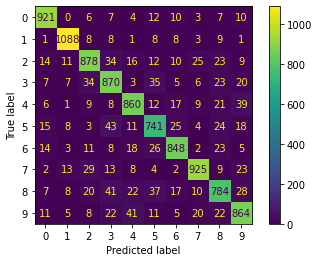

In [10]:
eval(
    decision_tree_pipeline,
    X_test,
    y_test
)

# Bagging Classifier

We instantiate a bagging classifier object with default parameters and train it.

Observe the mean `f1_score` and its standard deviation obtained by the classifier based on $10$-fold cross validation on the training set.

In [11]:
bagging_pipeline = Pipeline([
    ('classifier', BaggingClassifier(random_state=69))
])
train_classifiers(
    bagging_pipeline,
    X_train,
    y_train.ravel(),
    cv=shufflesplit_cv,
    name="Bagging Classifier"
)

On an average, Bagging Classifier model has f1 score of 0.939 +/- 0.003 on the training set.


Let's evaluate the trained classifer on the test set.

# Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.93      0.93      0.93      1010
           4       0.95      0.94      0.94       982
           5       0.93      0.92      0.93       892
           6       0.96      0.95      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.92      0.90      0.91       974
           9       0.95      0.92      0.94      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

# Confusion matrix: 


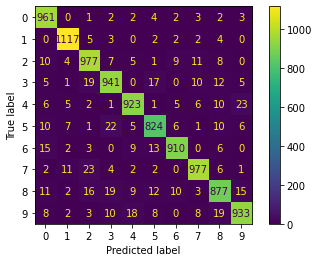

In [12]:
eval(
    bagging_pipeline,
    X_test,
    y_test
)

# Random Forest

We instantiate a Random Forest classifier object with default parameters and train it.

Observe the mean `f1_score` and its standard deviation obtained by the classifier based on $10$-fold cross validation on the training set.

In [13]:
random_forest_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=69))
])
train_classifiers(
    random_forest_pipeline,
    X_train,
    y_train.ravel(),
    cv=shufflesplit_cv,
    name="Random Forest Classifier"
)

On an average, Random Forest Classifier model has f1 score of 0.967 +/- 0.002 on the training set.


Let's evaluate this Random Forest classifier on the test set and obtain classification report containing prediction, recall, f1-score and accuracy for each class. It also calculates confusion matrix and displays it with `ConfusionMatrixDisplay` utility.

# Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

# Confusion matrix: 


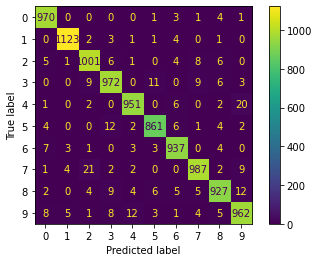

In [14]:
eval(
    random_forest_pipeline,
    X_test,
    y_test
)

# Summary

- We trained three multi-class classifiers for handwritten digit recognition.
- The decision tree classifier is a baseline classifier, which obtained an accuracy of $88\%$ on the test set.
- Usinf bagging and training on the same decision tree classifier gave us an increase of $6\%$ in accuracy, which translates to $94\%$ accuracy on the test set.
- Finally random forest pushed that further to a $97\%$ accuracy.
- We can see that how ensemble techniques give better results on the classification task compared to a single classifier.